In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cadet import Cadet
Cadet.cadet_path = 'D:\yuan_yunhao\Process modeling\cadet-cli.exe'

In [2]:
def GRM_partial_load(L, u, e, ep, rp, Da, kf, Dp, Ds, ka, kd, qmax, c_inj, q_ratio, tmax, time_step, col_step, par_step, dynamic):
    # Model setup
    model = Cadet()
    model.root.input.model.nunits = 3

    # Model inlet
    model.root.input.model.unit_000.unit_type = 'INLET'
    model.root.input.model.unit_000.ncomp = 1
    model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

    model.root.input.model.unit_001.unit_type = 'GENERAL_RATE_MODEL'
    model.root.input.model.unit_001.ncomp = 1
    
    ## Calculate total porosity
    et = e + (1-e)*ep
    
    ## Geometry
    model.root.input.model.unit_001.col_length = L                # m
    model.root.input.model.unit_001.velocity = u / et             # m/s (intersital and superficial conversion)
    model.root.input.model.unit_001.col_porosity = e             # -
    model.root.input.model.unit_001.par_porosity = ep             # -
    model.root.input.model.unit_001.par_radius = rp               # m

    ## Transport
    model.root.input.model.unit_001.col_dispersion = Da           # m^2 / s (interstitial volume)
    model.root.input.model.unit_001.film_diffusion = [kf]         # m / s
    model.root.input.model.unit_001.par_diffusion = [Dp,]        # m^2 / s (mobile phase)  
    model.root.input.model.unit_001.par_surfdiffusion = [Ds,]      # m^2 / s (solid phase)

    ## Binding model
    model.root.input.model.unit_001.adsorption_model = 'MULTI_COMPONENT_LANGMUIR'
    model.root.input.model.unit_001.adsorption.is_kinetic = dynamic    # Kinetic binding
    model.root.input.model.unit_001.adsorption.mcl_ka = [ka,]      # m^3 / (mol * s)   (mobile phase, Adsorption rate constants)
    model.root.input.model.unit_001.adsorption.mcl_kd = [kd,]         # 1 / s (kd, desorption)
    model.root.input.model.unit_001.adsorption.mcl_qmax = [qmax,]
    
    model.root.input.model.unit_001.init_c = [0.0,]
    model.root.input.model.unit_001.init_q = [q_ratio*qmax,]

    model.root.input.model.unit_002.unit_type = 'OUTLET'
    model.root.input.model.unit_002.ncomp = 1

    model.root.input.solver.sections.nsec = 1
    model.root.input.solver.sections.section_times = [0.0, tmax,]   # s
    model.root.input.solver.sections.section_continuity = []

    model.root.input.model.unit_000.sec_000.const_coeff = [c_inj,] # mol / m^3
    model.root.input.model.unit_000.sec_000.lin_coeff = [0.0,]
    model.root.input.model.unit_000.sec_000.quad_coeff = [0.0,]
    model.root.input.model.unit_000.sec_000.cube_coeff = [0.0,]

    Q = u

    model.root.input.model.connections.nswitches = 1
    model.root.input.model.connections.switch_000.section = 0
    model.root.input.model.connections.switch_000.connections = [
        0, 1, -1, -1, Q,  # [unit_000, unit_001, all components, all components, Q/ m^3*s^-1 
        1, 2, -1, -1, Q]  # [unit_001, unit_002, all components, all components, Q/ m^3*s^-1 

    ### Grid cells
    model.root.input.model.unit_001.discretization.ncol = col_step
    model.root.input.model.unit_001.discretization.npar = par_step

    ### Bound states
    model.root.input.model.unit_001.discretization.nbound = [1]

    ### Other options
    model.root.input.model.unit_001.discretization.par_disc_type = 'EQUIDISTANT_PAR'    
    model.root.input.model.unit_001.discretization.use_analytic_jacobian = 1
    model.root.input.model.unit_001.discretization.reconstruction = 'WENO'
    model.root.input.model.unit_001.discretization.gs_type = 1
    model.root.input.model.unit_001.discretization.max_krylov = 0
    model.root.input.model.unit_001.discretization.max_restarts = 10
    model.root.input.model.unit_001.discretization.schur_safety = 1.0e-8

    model.root.input.model.unit_001.discretization.weno.boundary_model = 0
    model.root.input.model.unit_001.discretization.weno.weno_eps = 1e-10
    model.root.input.model.unit_001.discretization.weno.weno_order = 3
    model.root.input.model.solver.gs_type = 1
    model.root.input.model.solver.max_krylov = 0
    model.root.input.model.solver.max_restarts = 10
    model.root.input.model.solver.schur_safety = 1e-8

    # Number of cores for parallel simulation
    model.root.input.solver.nthreads = 8

    # Tolerances for the time integrator
    model.root.input.solver.time_integrator.abstol = 1e-6
    model.root.input.solver.time_integrator.algtol = 1e-10
    model.root.input.solver.time_integrator.reltol = 1e-6
    model.root.input.solver.time_integrator.init_step_size = 1e-6
    model.root.input.solver.time_integrator.max_steps = 1000000

    # Return data
    model.root.input['return'].split_components_data = 0
    model.root.input['return'].split_ports_data = 0
    model.root.input['return'].unit_000.write_solution_bulk = 1
    model.root.input['return'].unit_000.write_solution_particle = 1
    model.root.input['return'].unit_000.write_solution_solid = 1
    

    # Copy settings to the other unit operations
    model.root.input['return'].unit_001 = model.root.input['return'].unit_000
    model.root.input['return'].unit_002 = model.root.input['return'].unit_000

    # Solution times
    model.root.input.solver.user_solution_times = np.linspace(0, tmax, time_step)

    model.filename = 'model-1.h5'
    model.save()

    data = model.run()

    if data.returncode == 0:
        print("Simulation completed successfully")
        model.load()   
    else:
        print(data)
        raise Exception("Simulation failed")

    # Collect return results
    c = model.root.output.solution.unit_001.solution_bulk
    cp = model.root.output.solution.unit_001.solution_particle
    cs = model.root.output.solution.unit_001.solution_solid
    
    return c, cp, cs

In [3]:
tmax =28800

time_step = 5000
col_step = 20
par_step = 6

time_scale = np.linspace(0, tmax, time_step)

In [9]:
L = 0.15788494290009666
u = 4.140068666150112e-05
e = 0.600799980523461
ep = 0.8359448555810729
rp = 0.00011957123060177692
Da = 2.07836452485902e-08
kf = 4.590419626691037e-05
Dp = 1.6803403649796172e-11
Ds = 7.134163425191481e-14
ka = 3.7698203876889015e-05
kd = 0.26101979293410316
qmax = 194.24200708557416
c_inj = 14.092416883005795
q_ratio = 0.2

In [10]:
c_2, cp_2, q_2 = GRM_partial_load(L, u, e, ep, rp, Da, kf, Dp, Ds, ka, kd, qmax, c_inj, q_ratio, 
                                       tmax, time_step, col_step, par_step, dynamic=True)

Simulation completed successfully


Text(0.5, 1.0, 'Intial Condition of Column at t=0')

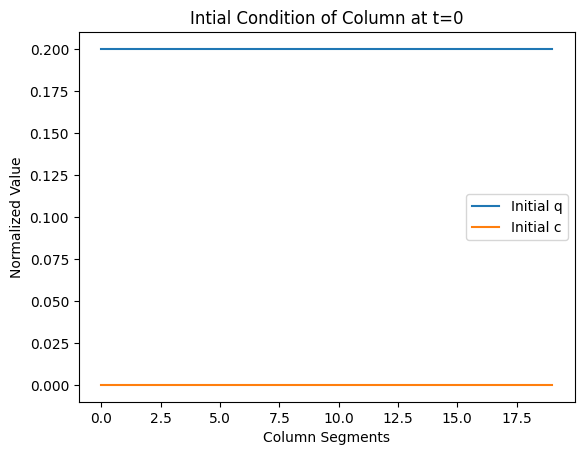

In [11]:
# Check Initial Conditions
plt.plot(q_2[0, :, 0].reshape(-1)/qmax, label='Initial q')
plt.plot(c_2[0, :,].reshape(-1)/qmax, label='Initial c')
plt.legend()
plt.xlabel('Column Segments')
plt.ylabel('Normalized Value')
plt.title('Intial Condition of Column at t=0')

In [12]:
q_ratio = 0.4

c_4, cp_4, q_4 = GRM_partial_load(L, u, e, ep, rp, Da, kf, Dp, Ds, ka, kd, qmax, c_inj, q_ratio, 
                                       tmax, time_step, col_step, par_step, dynamic=True)

Simulation completed successfully


In [13]:
q_ratio = 0

c_empty, cp_empty, q_empty = GRM_partial_load(L, u, e, ep, rp, Da, kf, Dp, Ds, ka, kd, qmax, c_inj, q_ratio, 
                                       tmax, time_step, col_step, par_step, dynamic=True)

Simulation completed successfully


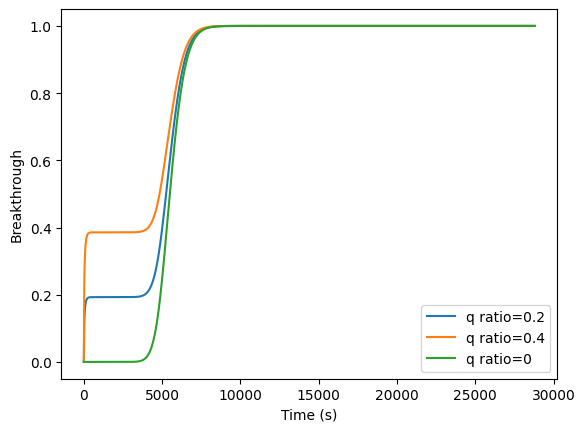

In [14]:
# Plot Breakthough Curve
plt.plot(time_scale, c_2[:, -1].reshape(-1)/c_inj, label='q ratio=0.2')
plt.plot(time_scale, c_4[:, -1].reshape(-1)/c_inj, label='q ratio=0.4')
plt.plot(time_scale, c_empty[:,-1].reshape(-1)/c_inj, label='q ratio=0')
plt.xlabel('Time (s)')
plt.ylabel('Breakthrough')
plt.legend()